In [ ]:
!pip install -U "datasets[audio]"


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 47.7/47.7 MB 14.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 511.6/511.6 kB 28.0 MB/s eta 0:00:00
  Attempting uninstall: pyarrow
    Found existing installation: pyarrow 18.1.0
    Uninstalling pyarrow-18.1.0:
      Successfully uninstalled pyarrow-18.1.0
  Attempting uninstall: datasets
    Found existing installation: datasets 4.0.0
    Uninstalling datasets-4.0.0:
      Successfully uninstalled datasets-4.0.0


In [ ]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from tokenizers import Tokenizer, models, pre_tokenizers, decoders
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
import torch.nn.functional as F
from torch.nn import MultiheadAttention
import os
import shutil

os.environ["TOKENIZERS_PARALLELISM"] = "true"
os.environ["PYTORCH_ENABLE_MPS_FALLBACK"] = "1"

In [ ]:
from datasets import load_dataset
dataset = load_dataset("m-aliabbas/idrak_timit_subsample1")



In [ ]:
dataset['train'][3]['audio']['array']

array([0.00012207, 0.00015259, 0.00015259, ..., 0.00018311, 0.00018311,
       0.00018311], dtype=float32)

In [ ]:
example = dataset["train"][3]        # one row
audio_info = example["audio"]        # dict with array, path, sampling_rate
audio_array = audio_info["array"]    # 1D NumPy array
sample_rate = audio_info["sampling_rate"]
transcript = example["transcription"]


In [ ]:
example

{'audio': <datasets.features._torchcodec.AudioDecoder at 0x784b03ea5520>,
 'transcription': 'he picked up nine pairs of socks for each brother'}

In [ ]:
audio_info

In [ ]:
audio_array

array([0.00012207, 0.00015259, 0.00015259, ..., 0.00018311, 0.00018311,
       0.00018311], dtype=float32)

In [ ]:
sample_rate

16000

In [ ]:
transcript

'he picked up nine pairs of socks for each brother'

In [ ]:
from IPython.display import Audio

Audio(audio_array,rate=sample_rate)

In [ ]:
def plot_segment(audio_array, sample_rate, start_ms=0, end_ms=None):
    if end_ms is None:
        end_ms = len(audio_array) * 1000 / sample_rate

    # convert times (ms) -> sample indices
    start_idx = int(start_ms * sample_rate / 1000)
    end_idx = int(end_ms * sample_rate / 1000)

    segment = audio_array[start_idx:end_idx]

    # time axis for this segment, in ms
    time_ms = np.arange(len(segment)) * (1000 / sample_rate) + start_ms

    plt.figure(figsize=(12, 4))
    plt.plot(time_ms, segment)
    plt.title(f"Audio Waveform ({start_ms}–{end_ms} ms)")
    plt.xlabel("Time (ms)")
    plt.ylabel("Amplitude")
    plt.grid(True)
    plt.tight_layout()
    plt.show()


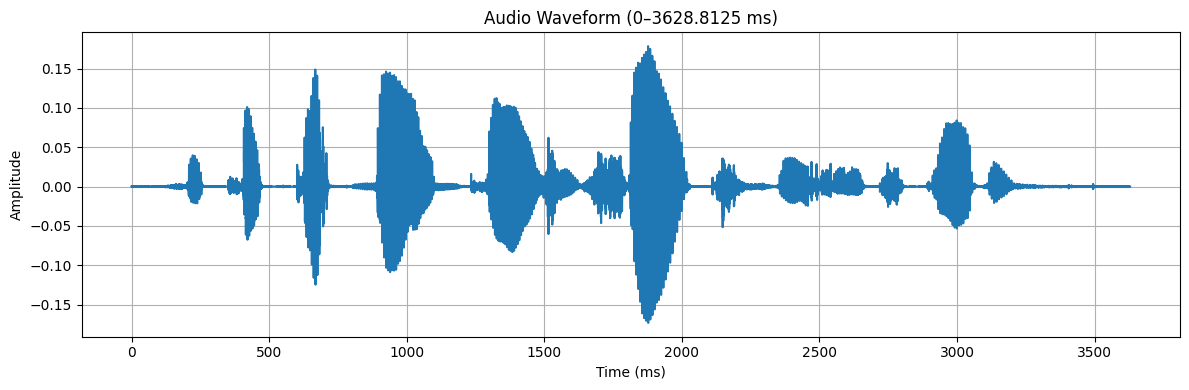

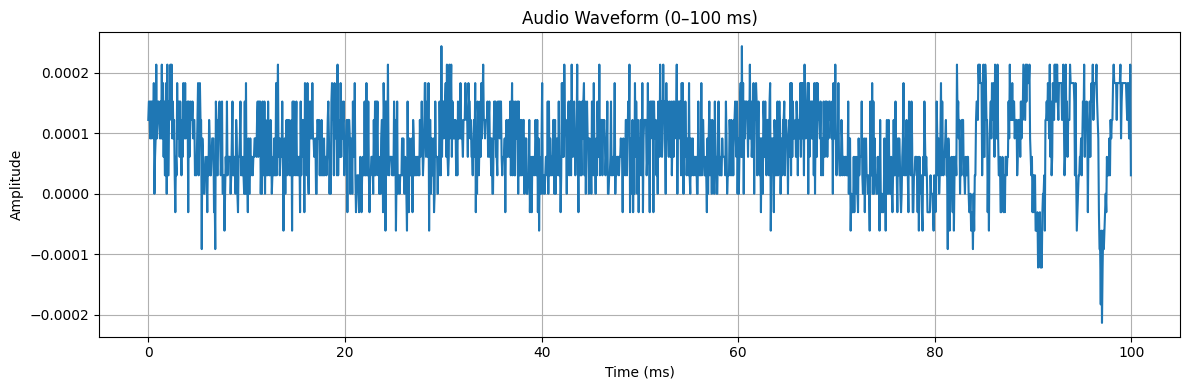

In [ ]:
plot_segment(audio_array, sample_rate)              # full signal
plot_segment(audio_array, sample_rate, 0, 100)   # 0.5s–1.5s

# Tokenizer

In [ ]:
def get_tokenizer(save_path="tokenizer.json"):
    # Create an empty BPE model
    tokenizer = Tokenizer(models.BPE())

    # Add a special blank / padding token
    tokenizer.add_special_tokens(["▁"])   # you can change this symbol

    # Add character-level tokens: A–Z and space
    tokenizer.add_tokens(list("ABCDEFGHIJKLMNOPQRSTUVWXYZ "))

    # Byte-level pre-tokenizer and decoder (handles spacing/bytes cleanly)
    tokenizer.pre_tokenizer = pre_tokenizers.ByteLevel(add_prefix_space=True)
    tokenizer.decoder = decoders.ByteLevel()

    # Optionally remember the id of the blank token
    tokenizer.blank_token = tokenizer.token_to_id("▁")

    # Save to disk so you can reload later
    tokenizer.save(save_path)

    return tokenizer

In [ ]:
tokenizer = get_tokenizer()

In [ ]:
tokenizer.get_vocab()

{'C': 3,
 'L': 12,
 'Z': 26,
 'A': 1,
 'J': 10,
 'N': 14,
 'S': 19,
 'Q': 17,
 'E': 5,
 'O': 15,
 'X': 24,
 'I': 9,
 'T': 20,
 '▁': 0,
 'W': 23,
 ' ': 27,
 'Y': 25,
 'H': 8,
 'P': 16,
 'V': 22,
 'D': 4,
 'G': 7,
 'R': 18,
 'M': 13,
 'K': 11,
 'B': 2,
 'U': 21,
 'F': 6}

In [ ]:
transcript = transcript.upper()

In [ ]:
encoded = tokenizer.encode(transcript)
print(encoded.ids)      # token IDs
print(encoded.tokens)   # token strings

[8, 5, 27, 16, 9, 3, 11, 5, 4, 27, 21, 16, 27, 14, 9, 14, 5, 27, 16, 1, 9, 18, 19, 27, 15, 6, 27, 19, 15, 3, 11, 19, 27, 6, 15, 18, 27, 5, 1, 3, 8, 27, 2, 18, 15, 20, 8, 5, 18]
['H', 'E', ' ', 'P', 'I', 'C', 'K', 'E', 'D', ' ', 'U', 'P', ' ', 'N', 'I', 'N', 'E', ' ', 'P', 'A', 'I', 'R', 'S', ' ', 'O', 'F', ' ', 'S', 'O', 'C', 'K', 'S', ' ', 'F', 'O', 'R', ' ', 'E', 'A', 'C', 'H', ' ', 'B', 'R', 'O', 'T', 'H', 'E', 'R']


# Dataloader

In [ ]:
class VoiceDataset(Dataset):
    def __init__(self, hf_dataset, num_examples=None, tokenizer=None):
        self.dataset = hf_dataset
        self.num_examples = (
            min(num_examples, len(hf_dataset)) if num_examples is not None
            else len(hf_dataset)
        )
        self.tokenizer = tokenizer

    def __len__(self):
        return self.num_examples

    def __getitem__(self, idx):
        item = self.dataset[idx]

        # audio -> float32 tensor
        waveform = torch.from_numpy(item["audio"]["array"]).float()

        # text -> uppercase
        text = item["transcription"].upper()

        if self.tokenizer is not None:
            encoded = self.tokenizer.encode(text)
            input_ids = torch.tensor(encoded.ids, dtype=torch.long)
            return {
                "audio": waveform,
                "text": text,          # <-- keep raw transcript
                "input_ids": input_ids,
            }

        return {"audio": waveform, "text": text}


# Collate Function

In [ ]:
def collate_fn(batch):
    # Audio: pad to max length
    audio_tensors = [b["audio"] for b in batch]
    max_audio_len = max(a.shape[-1] for a in audio_tensors)
    padded_audio = torch.stack([
        torch.nn.functional.pad(a, (0, max_audio_len - a.shape[-1]))
        for a in audio_tensors
    ], dim=0)  # (B, T_audio)

    # input_ids: pad with 0 (PAD/blank)
    input_ids_list = [b["input_ids"] for b in batch]
    max_txt_len = max(t.shape[-1] for t in input_ids_list)
    padded_input_ids = torch.stack([
        torch.nn.functional.pad(t, (0, max_txt_len - t.shape[-1]), value=0)
        for t in input_ids_list
    ], dim=0)  # (B, T_text)

    # raw transcripts
    texts = [b["text"] for b in batch]

    return {
        "audio": padded_audio,
        "input_ids": padded_input_ids,
        "text": texts,
    }


In [ ]:
def get_dataset(batch_size=32, num_examples=None, num_workers=4):
    # load HF dataset split
    hf_ds = load_dataset("m-aliabbas/idrak_timit_subsample1", split="train")  # [web:4]

    tokenizer = get_tokenizer()

    dataset = VoiceDataset(
        hf_dataset=hf_ds,
        tokenizer=tokenizer,
        num_examples=num_examples,
    )

    dataloader = DataLoader(
        dataset,
        batch_size=batch_size,
        shuffle=True,
        collate_fn=collate_fn,
        num_workers=num_workers,
    )

    return dataloader


In [ ]:
if __name__ == "__main__":
    dataloader = get_dataset(batch_size=4)
    for batch in dataloader:
        audio = batch["audio"]      # (B, T_audio)
        input_ids = batch["input_ids"]  # (B, T_text)
        print(audio.shape, input_ids.shape)
        break


/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


torch.Size([4, 48845]) torch.Size([4, 58])


In [ ]:
input_ids[:4]

tensor([[23,  8, 25, 27, 16, 21, 20, 27, 19, 21,  3,  8, 27,  1, 27,  8,  9,  7,
          8, 27, 22,  1, 12, 21,  5, 27, 15, 14, 27,  2,  5,  9, 14,  7, 27, 20,
         15, 16, 27,  4, 15,  7,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
          0,  0,  0,  0],
        [ 8,  5, 27,  3,  8, 21,  3, 11, 12,  5,  4, 27, 27, 20,  8,  5, 27, 13,
          5, 13, 15, 18, 25, 27, 22,  9, 22,  9,  4,  0,  0,  0,  0,  0,  0,  0,
          0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
          0,  0,  0,  0],
        [ 2, 25, 27,  5,  1, 20,  9, 14,  7, 27, 25, 15,  7, 21, 18, 20, 27, 27,
         25, 15, 21, 27, 13,  1, 25, 27, 12,  9, 22,  5, 27, 12, 15, 14,  7,  5,
         18,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
          0,  0,  0,  0],
        [20,  8,  5, 27, 15, 22,  5, 18, 23,  5,  9,  7,  8, 20, 27,  3,  8,  1,
         18, 13,  5, 18, 27,  3, 15, 21, 12,  4, 27, 19, 12,  9, 16, 27, 16, 15,
          9, 19, 15, 14, 27,  9

In [ ]:
audio[:4]

tensor([[-3.0518e-05,  1.5259e-04, -5.1880e-04,  ...,  0.0000e+00,
          0.0000e+00,  0.0000e+00],
        [ 1.5259e-04,  1.8311e-04, -9.1553e-05,  ...,  0.0000e+00,
          0.0000e+00,  0.0000e+00],
        [ 1.2207e-04,  6.1035e-05,  3.0518e-05,  ...,  0.0000e+00,
          0.0000e+00,  0.0000e+00],
        [-6.1035e-05,  0.0000e+00,  6.1035e-05,  ..., -9.1553e-05,
         -3.0518e-05, -9.1553e-05]])

In [ ]:
audio.shape

torch.Size([4, 48845])

# Residual Downsampling Block

In [ ]:
class ResidualDownSampleBlock(nn.Module):
    def __init__(self, in_channels, out_channels, stride, kernel_size=4):
        super().__init__()

        # First conv keeps temporal length (padding="same")
        self.conv1 = nn.Conv1d(
            in_channels,
            out_channels,
            kernel_size=kernel_size,
            padding="same",
        )
        self.bn1 = nn.BatchNorm1d(out_channels)

        # Second conv does the actual downsampling via stride
        self.conv2 = nn.Conv1d(
            out_channels,
            out_channels,
            kernel_size=kernel_size,
            stride=stride,
        )

        self.relu = nn.ReLU()

    def forward(self, x):
        # x: (batch, channels, time)
        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out) + x         # residual connection
        out = self.conv2(out)
        return out


# Full Downsampling Network

In [ ]:
class DownsamplingNetwork(nn.Module):
    def __init__(
        self,
        embedding_dim=128,
        hidden_dim=64,
        in_channels=1,
        initial_mean_pooling_kernel_size=2,
        strides=(6, 8, 4, 2),
    ):
        super().__init__()

        self.layers = nn.ModuleList()

        # First reduce temporal length a bit with pooling
        self.mean_pooling = nn.AvgPool1d(
            kernel_size=initial_mean_pooling_kernel_size
        )

        # Stack of residual downsampling blocks
        for i, s in enumerate(strides):
            block_in_channels = hidden_dim if i > 0 else in_channels
            self.layers.append(
                ResidualDownSampleBlock(
                    in_channels=block_in_channels,
                    out_channels=hidden_dim,
                    stride=s,
                    kernel_size=8,
                )
            )

        # Final projection to transformer embedding dimension
        self.final_conv = nn.Conv1d(
            hidden_dim,
            embedding_dim,
            kernel_size=4,
            padding="same",
        )

    def forward(self, x):
        # x: (batch, 1, time)
        x = self.mean_pooling(x)
        for layer in self.layers:
            x = layer(x)

        x = self.final_conv(x)  # (B, embedding_dim, T')
        x = x.transpose(1, 2)   # (B, T', embedding_dim) for the transformer
        return x


In [ ]:
downsampling_network = DownsamplingNetwork(
    embedding_dim=32,      # or whatever you chose
    hidden_dim=16,
    in_channels=1,
    initial_mean_pooling_kernel_size=2,
    strides=(6, 8, 4, 2),
)


# Test run

In [ ]:
if __name__ == "__main__":
    batch_size = 2
    input_embedding_dim = 1
    seq_len = 237680

    output_embedding_dim = 32
    hidden_dim = 16
    strides = [2, 4, 8]
    initial_kernel = 2

    net = DownsamplingNetwork(
        embedding_dim=output_embedding_dim,
        hidden_dim=hidden_dim,
        in_channels=input_embedding_dim,
        initial_mean_pooling_kernel_size=initial_kernel,
        strides=strides,
    )

    x = torch.randn(batch_size, 1, seq_len)
    y = net(x)
    print("output shape:", y.shape)  # e.g. (2, 1856, 32) depending on strides


/usr/local/lib/python3.12/dist-packages/torch/nn/modules/conv.py:366: UserWarning: Using padding='same' with even kernel lengths and odd dilation may require a zero-padded copy of the input be created (Triggered internally at /pytorch/aten/src/ATen/native/Convolution.cpp:1031.)
  return F.conv1d(


output shape: torch.Size([2, 1856, 32])


# Visualizer

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation

def visualize_downsampling(x, y, kernel_size=8, stride=2, fps=5, save_path=None):
    """
    x: 1D numpy input signal
    y: 1D numpy output signal (after conv+stride, single channel)
    kernel_size: conv kernel size
    stride: conv stride
    fps: frames per second for animation
    save_path: if not None, path to save mp4/gif
    """
    x = np.asarray(x)
    y = np.asarray(y)

    fig, (ax_in, ax_out) = plt.subplots(2, 1, figsize=(12, 6), sharex=False)

    # Input signal
    ax_in.set_title("Input signal")
    ax_in.set_ylabel("Amplitude")
    ax_in.plot(np.arange(len(x)), x, color="lightcoral")
    kernel_region, = ax_in.plot([], [], color="royalblue", linewidth=3)

    # Output signal
    ax_out.set_title(f"Downsampled output (stride={stride}, kernel={kernel_size})")
    ax_out.set_xlabel("Time index")
    ax_out.set_ylabel("Amplitude")
    out_bars = ax_out.bar(np.arange(len(y)), y, color="orchid")

    fig.tight_layout()

    # Number of positions where the kernel is applied
    num_steps = min(len(y), (len(x) - kernel_size) // stride + 1)

    def init():
        kernel_region.set_data([], [])
        return [kernel_region] + list(out_bars)

    def update(step):
        # input region for this output position
        start = step * stride
        end = start + kernel_size
        xs = np.arange(start, end)
        ys = x[start:end]

        kernel_region.set_data(xs, ys)

        # highlight current output bar
        for i, b in enumerate(out_bars):
            if i == step:
                b.set_color("dodgerblue")
            else:
                b.set_color("orchid")

        return [kernel_region] + list(out_bars)

    anim = FuncAnimation(
        fig,
        update,
        frames=num_steps,
        init_func=init,
        interval=1000 / fps,
        blit=True,
        repeat=True,
    )

    if save_path is not None:
        # requires ffmpeg or imagemagick depending on extension
        anim.save(save_path, dpi=120)

    plt.show()
    return anim


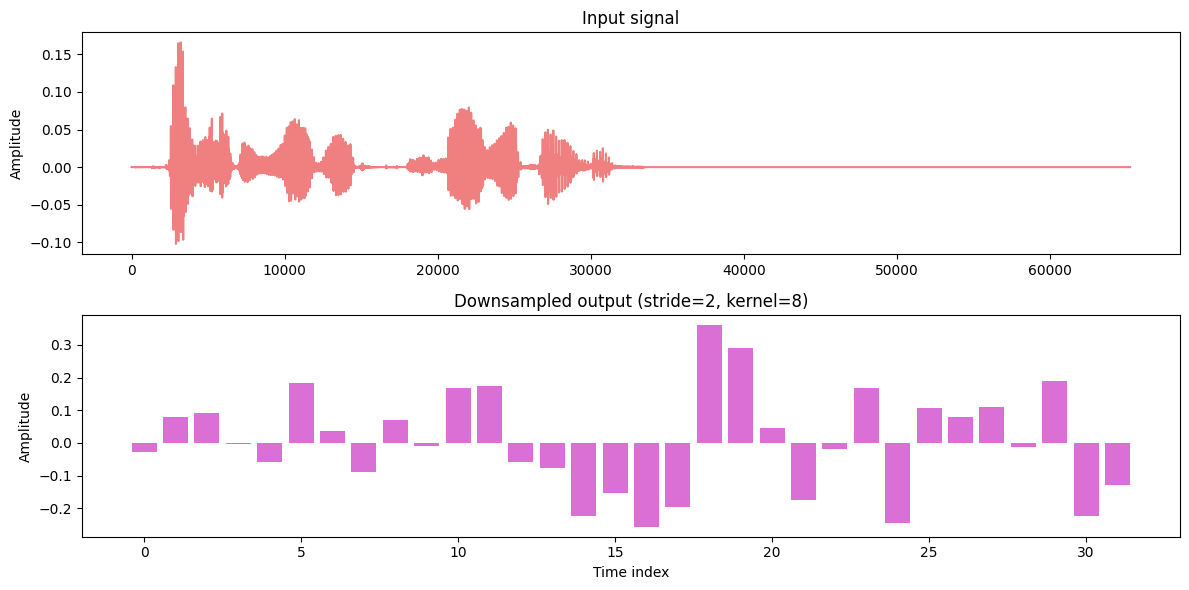

In [ ]:
# 1) Get a batch from your dataloader
batch = next(iter(dataloader))          # {"audio": (B, T), "input_ids": ...}
audio_batch = batch["audio"]            # shape (B, T)

# 2) Make it (B, C, T) for Conv1d
x_tensor = audio_batch.unsqueeze(1)     # C = 1

# 3) Run through your downsampling network/block
with torch.no_grad():
    y_tensor = downsampling_network(x_tensor)   # or downsampling_block(x_tensor)

# 4) Pick first example & first channel and convert to numpy
x_np = x_tensor[0, 0].cpu().numpy()
y_np = y_tensor[0, 0].cpu().numpy() if y_tensor.ndim == 3 else y_tensor[0].cpu().numpy()

# 5) Visualize
visualize_downsampling(x_np, y_np, kernel_size=8, stride=2)


# Attention

In [ ]:
class FeedForward(nn.Module):
    def __init__(self, embed_size: int, ff_hidden_mult: int = 4, dropout: float = 0.1):
        super().__init__()
        hidden = ff_hidden_mult * embed_size
        self.layer1 = nn.Linear(embed_size, hidden)
        self.layer2 = nn.Linear(hidden, embed_size)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        x = self.layer1(x)
        x = F.gelu(x)
        x = self.dropout(x)
        x = self.layer2(x)
        return x


In [ ]:
class SelfAttentionLayer(nn.Module):
    def __init__(self, embed_size: int, num_heads: int, dropout: float = 0.1):
        super().__init__()
        self.embed_size = embed_size
        self.num_heads = num_heads

        # batch_first=True so we keep (batch, seq, embed) everywhere [web:134][web:136]
        self.mha = MultiheadAttention(
            embed_dim=embed_size,
            num_heads=num_heads,
            dropout=dropout,
            batch_first=True,
        )

        self.attn_dropout = nn.Dropout(dropout)
        self.attn_norm = nn.LayerNorm(embed_size)

        self.ff = FeedForward(embed_size, dropout=dropout)
        self.ff_dropout = nn.Dropout(dropout)
        self.ff_norm = nn.LayerNorm(embed_size)

    def forward(self, x: torch.Tensor, attn_mask: torch.Tensor | None = None):
        """
        x: (batch, seq_len, embed_size)
        attn_mask: optional mask of shape (batch, seq_len) or (seq_len, seq_len)
        """
        # Multi‑head self‑attention
        attn_out, attn_weights = self.mha(
            query=x,
            key=x,
            value=x,
            key_padding_mask=attn_mask,   # or use attn_mask=... for causal masks
            need_weights=True,
        )

        # Residual + norm
        x = self.attn_norm(x + self.attn_dropout(attn_out))

        # Feed‑forward block with residual + norm
        ff_out = self.ff(x)
        x = self.ff_norm(x + self.ff_dropout(ff_out))

        return x, attn_weights


In [ ]:
class SinusoidalPositionEncoding(nn.Module):
    def __init__(self, embed_size: int, max_seq_length: int):
        super().__init__()
        position = torch.arange(max_seq_length).unsqueeze(1)         # (T, 1)
        div_term = torch.exp(
            torch.arange(0, embed_size, 2) * (-torch.log(torch.tensor(10000.0)) / embed_size)
        )                                                             # (E/2,)
        pe = torch.zeros(max_seq_length, embed_size)
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        self.register_buffer("positional_embedding", pe)             # (T, E)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        # x: (batch, seq_len, embed_size)
        seq_len = x.size(1)
        return x + self.positional_embedding[:seq_len, :]


In [ ]:
class TransformerEncoder(nn.Module):
    def __init__(self, embed_size: int, num_layers: int, num_heads: int, max_seq_length: int):
        super().__init__()
        self.positional_encoding = SinusoidalPositionEncoding(embed_size, max_seq_length)
        self.transformer_blocks = nn.ModuleList(
            [SelfAttentionLayer(embed_size, num_heads) for _ in range(num_layers)]
        )

    def forward(self, x: torch.Tensor, attn_mask: torch.Tensor | None = None):
        """
        x: (batch, seq_len, embed_size) from the DownsamplingNetwork
        """
        x = self.positional_encoding(x)
        for block in self.transformer_blocks:
            x, _ = block(x, attn_mask=attn_mask)
        return x


# Simple Vector Quantizer

In [ ]:
class VectorQuantizer(nn.Module):
    def __init__(self, num_embeddings: int, embedding_dim: int, commitment_cost: float = 0.25):
        super().__init__()
        self.num_embeddings = num_embeddings
        self.embedding_dim = embedding_dim
        self.commitment_cost = commitment_cost

        # Codebook: N x D
        self.embedding = nn.Embedding(num_embeddings, embedding_dim)
        nn.init.uniform_(self.embedding.weight, -0.1, 0.1)

    def forward(self, x: torch.Tensor):
        """
        x: (batch, seq_len, embedding_dim)
        returns:
          quantized: (batch, seq_len, embedding_dim)
          loss: scalar VQ loss
        """
        batch_size, seq_len, embed_dim = x.shape
        flat_x = x.reshape(batch_size * seq_len, embed_dim)         # (B*T, D)

        # Distances between each vector and all codebook entries [web:163][web:161]
        distances = torch.cdist(flat_x, self.embedding.weight, p=2) # (B*T, N)

        # Nearest code index per vector
        encoding_indices = torch.argmin(distances, dim=1)           # (B*T,)

        # Look up quantized vectors and reshape back
        quantized = self.embedding(encoding_indices).view(
            batch_size, seq_len, embed_dim
        )

        # VQ-VAE loss: codebook + commitment [web:158][web:160]
        e_latent_loss = F.mse_loss(quantized.detach(), x)
        q_latent_loss = F.mse_loss(quantized, x.detach())
        loss = q_latent_loss + self.commitment_cost * e_latent_loss

        # Straight-through estimator
        quantized = x + (quantized - x).detach()

        return quantized, loss


# Residual Vector Quantizer

In [ ]:
class ResidualVectorQuantizer(nn.Module):
    def __init__(self, num_codebooks: int, codebook_size: int, embedding_dim: int, commitment_cost: float = 0.25):
        super().__init__()
        self.codebooks = nn.ModuleList(
            [
                VectorQuantizer(codebook_size, embedding_dim, commitment_cost)
                for _ in range(num_codebooks)
            ]
        )

    def forward(self, x: torch.Tensor):
        """
        x: (batch, seq_len, embedding_dim)
        returns:
          out: (batch, seq_len, embedding_dim)  # sum of all quantized residuals
          total_loss: scalar (sum of VQ losses over codebooks)
        """
        residual = x
        out = torch.zeros_like(x)
        total_loss = 0.0

        for codebook in self.codebooks:
            this_output, this_loss = codebook(residual)
            residual = residual - this_output
            out = out + this_output
            total_loss = total_loss + this_loss

        return out, total_loss


# Transcribe Model

In [ ]:
class TranscribeModel(nn.Module):
    def __init__(
        self,
        num_codebooks: int,
        codebook_size: int,
        embedding_dim: int,
        vocab_size: int,
        strides: list[int],
        initial_mean_pooling_kernel_size: int,
        num_transformer_layers: int,
        max_seq_length: int = 2000,
        num_heads: int = 8,
    ):
        super().__init__()

        # store for saving/loading
        self.options = {
            "num_codebooks": num_codebooks,
            "codebook_size": codebook_size,
            "embedding_dim": embedding_dim,
            "vocab_size": vocab_size,
            "strides": strides,
            "num_transformer_layers": num_transformer_layers,
            "initial_mean_pooling_kernel_size": initial_mean_pooling_kernel_size,
            "max_seq_length": max_seq_length,
        }

        # 1) Conv front‑end
        self.downsampling_network = DownsamplingNetwork(
            embedding_dim=embedding_dim,
            hidden_dim=embedding_dim // 2,
            in_channels=1,
            initial_mean_pooling_kernel_size=initial_mean_pooling_kernel_size,
            strides=strides,
        )

        # 2) Transformer encoder before RVQ
        self.pre_rvq_transformer = TransformerEncoder(
            embed_size=embedding_dim,
            num_layers=num_transformer_layers,
            max_seq_length=max_seq_length,
            num_heads=8,
        )

        # 3) Residual vector quantizer over encoder features
        self.rvq = ResidualVectorQuantizer(
            num_codebooks=num_codebooks,
            codebook_size=codebook_size,
            embedding_dim=embedding_dim,
        )

        # 4) Output projection to vocab
        self.output_layer = nn.Linear(embedding_dim, vocab_size)

    def forward(self, x: torch.Tensor):
        """
        x: (batch, time) raw audio waveform (already normalized / resampled)
        returns:
            log_probs: (batch, T', vocab_size)
            vq_loss: scalar auxiliary loss from RVQ
        """
        vq_loss = torch.tensor(0.0, device=x.device)

        # add channel dimension for Conv1d: (B, 1, T)
        x = x.unsqueeze(1)

        # conv downsampling: (B, T_conv, D)
        x = self.downsampling_network(x)

        # transformer encoder: (B, T_enc, D)
        x = self.pre_rvq_transformer(x)

        # RVQ over encoder features
        x, vq_loss = self.rvq(x)

        # project to vocabulary and log‑softmax for CTC / seq‑loss
        x = self.output_layer(x)          # (B, T_enc, vocab)
        x = torch.log_softmax(x, dim=-1)  # log‑probs

        return x, vq_loss

    # --------- saving / loading helpers ---------

    def save(self, path: str):
        print("Saving model to", path)
        torch.save({"model": self.state_dict(), "options": self.options}, path)

    @staticmethod
    def load(path: str, map_location: str | torch.device | None = None):
        print("Loading model from", path)
        checkpoint = torch.load(path, map_location=map_location)
        model = TranscribeModel(**checkpoint["options"])
        model.load_state_dict(checkpoint["model"])
        return model


In [ ]:
# ----- training hyper‑parameters -----
vq_initial_loss_weight = 10.0
vq_warmup_steps = 1000
vq_final_loss_weight = 0.5

num_epochs = 1000
starting_steps = 0
num_examples = None          # or an int subset
model_id = "test37"
num_batch_repeats = 1

BATCH_SIZE = 64
LEARNING_RATE = 0.005
log_dir = f"runs/{model_id}"
models_dir = f"models/{model_id}"
os.makedirs(models_dir, exist_ok=True)

# CTC Loss Helper

In [ ]:
def run_loss_function(log_probs: torch.Tensor, target: torch.Tensor, blank_token: int) -> torch.Tensor:
    """
    log_probs: (batch, T, vocab)
    target: (batch, U)
    """
    loss_function = nn.CTCLoss(blank=blank_token, zero_infinity=True)

    # input lengths: all time steps used for each example
    input_lengths = tuple(log_probs.shape[1] for _ in range(log_probs.shape[0]))

    # target lengths: ignore blank pad tokens
    target_lengths = (target != blank_token).sum(dim=1)
    target_lengths = tuple(t.item() for t in target_lengths)

    # CTC expects (T, batch, vocab)
    input_seq_first = log_probs.permute(1, 0, 2)
    loss = loss_function(input_seq_first, target, input_lengths, target_lengths)
    return loss


# Summary Writter

In [ ]:
from torch.utils.tensorboard import SummaryWriter


In [ ]:
def decode_ctc_output(log_probs_batch, tokenizer, blank_token: int):
    """
    Greedy CTC decoding.

    log_probs_batch: (B, T, V)  log-probs after log_softmax
    tokenizer: tokenizer with .decode(ids) method
    blank_token: ID used for CTC blank

    returns: list[str] decoded transcripts
    """
    # Argmax over vocab to get most probable token at each timestep
    pred_ids = log_probs_batch.argmax(dim=-1)  # (B, T)

    decoded_texts = []

    for seq in pred_ids:  # seq: (T,)
        prev = blank_token
        ids = []

        for t in seq.tolist():
            # CTC rule: remove blanks, collapse repeats
            if t != blank_token and t != prev:
                ids.append(t)
            prev = t

        # Decode token IDs to text
        if len(ids) == 0:
            decoded_texts.append("")  # empty if nothing decoded
        else:
            decoded_texts.append(tokenizer.decode(ids))

    return decoded_texts


In [ ]:
def main():
    # reset log dir
    if os.path.exists(log_dir):
        shutil.rmtree(log_dir)
    writer = SummaryWriter(log_dir)

    tokenizer = get_tokenizer()
    blank_token = tokenizer.token_to_id(" ")   # same as in tokenizer

    device = torch.device(
        "cuda" if torch.cuda.is_available()
        else "mps" if torch.backends.mps.is_available()
        else "cpu"
    )
    print(f"Using device: {device}")

    latest_path = f"{models_dir}/model_latest.pth"
    if os.path.exists(latest_path):
        print(f"Loading model from {latest_path}")
        model = TranscribeModel.load(latest_path, map_location=device).to(device)
        steps = starting_steps
    else:
        model = TranscribeModel(
            num_codebooks=2,
            codebook_size=32,
            embedding_dim=32,
            vocab_size=len(tokenizer.get_vocab()),
            strides=[6, 6, 6],
            initial_mean_pooling_kernel_size=4,
            num_transformer_layers=2,
            max_seq_length=400,
            num_heads=4,
        ).to(device)
        steps = 0

    num_trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
    print(f"Number of trainable parameters: {num_trainable_params}")

    optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)

    dataloader = get_dataset(
        batch_size=BATCH_SIZE,
        num_examples=num_examples,
        num_workers=1,
    )

    ctc_losses = []
    vq_losses = []

    for epoch in range(num_epochs):
        for idx, batch in enumerate(dataloader):
            for _ in range(num_batch_repeats):
                # audio: (B, T_audio) already as torch.Tensor from your collate_fn
                audio = batch["audio"].to(device)

                # input_ids: (B, T_text) already as torch.Tensor from your collate_fn
                target = batch["input_ids"].to(device)

                # Ensure audio is at least as long as target along time for CTC sanity
                if target.shape[1] > audio.shape[1]:
                    print(
                        "Padding audio, target is longer than audio. Audio shape:",
                        audio.shape, "Target Shape:", target.shape,
                    )
                    pad_amount = target.shape[1] - audio.shape[1]
                    audio = torch.nn.functional.pad(audio, (0, pad_amount), value=0.0)

                optimizer.zero_grad()
                output, vq_loss = model(audio)          # (B, T', vocab)

                ctc_loss = run_loss_function(output, target, blank_token)

                # linear warmup schedule for vq_loss weight
                vq_loss_weight = max(
                    vq_final_loss_weight,
                    vq_initial_loss_weight
                    - (vq_initial_loss_weight - vq_final_loss_weight)
                    * (steps / vq_warmup_steps),
                )

                if vq_loss is None:
                    loss = ctc_loss
                else:
                    loss = ctc_loss + vq_loss_weight * vq_loss

                if torch.isinf(loss) or torch.isnan(loss):
                    print("Loss is invalid, skipping step", audio.shape, target.shape)
                    continue

                loss.backward()
                torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=10.0)
                optimizer.step()

                ctc_losses.append(ctc_loss.item())
                if vq_loss is not None:
                    vq_losses.append(vq_loss.item())
                steps += 1

                if steps % 20 == 0:
                    avg_ctc_loss = sum(ctc_losses) / len(ctc_losses)
                    avg_vq_loss = sum(vq_losses) / len(vq_losses) if vq_losses else 0.0
                    avg_loss = avg_ctc_loss + vq_loss_weight * avg_vq_loss

                    print(
                        f"Epoch {epoch+1}, Step {steps}, Batch {idx+1}/{len(dataloader)}, "
                        f"CTC: {avg_ctc_loss:.3f}, VQ: {avg_vq_loss:.3f}, "
                        f"Total: {avg_loss:.3f}, vq_w: {vq_loss_weight:.3f}"
                    )

                    writer.add_scalar("loss/ctc", avg_ctc_loss, steps)
                    writer.add_scalar("loss/vq", avg_vq_loss, steps)
                    writer.add_scalar("loss/total", avg_loss, steps)
                    writer.add_scalar("loss/vq_weight", vq_loss_weight, steps)

                    ctc_losses = []
                    vq_losses = []

        # --- Evaluation and printing predictions at the end of each epoch ---
        model.eval() # Set model to evaluation mode
        with torch.no_grad():
            # For simplicity, we'll use the first batch of the current epoch for evaluation display.
            # In a real scenario, you'd use a separate validation dataset/dataloader.
            # We use next(iter(dataloader)) again to get a fresh batch from the start of the epoch's data.
            # Note: this might repeat data if num_workers=0 or batch_size is small and data is limited.
            eval_batch = next(iter(dataloader))
            audio_eval = eval_batch["audio"].to(device)
            ground_truth_texts = eval_batch["text"] # Raw texts from collate_fn

            output_eval, _ = model(audio_eval) # (B, T', vocab)

            predicted_texts = decode_ctc_output(output_eval, tokenizer, blank_token)

            print(f"\n--- Evaluation Sample for Epoch {epoch+1} ---")
            for i in range(min(5, len(ground_truth_texts))): # Print first 5 examples
                print(f"  Ground Truth: \"{ground_truth_texts[i]}\"")
                print(f"  Prediction:   \"{predicted_texts[i]}\"")
            print("------------------------------------------\n")
        model.train() # Set model back to training mode

        model.save(latest_path)

In [ ]:
if __name__ == "__main__":
    main()


Using device: cpu
Loading model from models/test37/model_latest.pth
Loading model from models/test37/model_latest.pth
Number of trainable parameters: 41020
Epoch 1, Step 20, Batch 20/21, CTC: 1.501, VQ: 0.129, Total: 2.766, vq_w: 9.819

--- Evaluation Sample for Epoch 1 ---
  Ground Truth: "ANY RETALIATORY GAS ATTACK WOULD BE AIRBORNE"
  Prediction:   ""
  Ground Truth: "CLIFF S DISPLAY WAS MISPLACED ON THE SCREEN"
  Prediction:   ""
  Ground Truth: "THE OVERWEIGHT CHARMER COULD SLIP POISON INTO ANYONE S TEA"
  Prediction:   ""
  Ground Truth: "DON T ASK ME TO CARRY AN OILY RAG LIKE THAT"
  Prediction:   ""
  Ground Truth: "DON T ASK ME TO CARRY AN OILY RAG LIKE THAT"
  Prediction:   ""
------------------------------------------

Saving model to models/test37/model_latest.pth
Epoch 2, Step 40, Batch 19/21, CTC: 1.403, VQ: 0.125, Total: 2.609, vq_w: 9.630

--- Evaluation Sample for Epoch 2 ---
  Ground Truth: "THE COWBOY CALLED THIS BREED OF CATTLE MAGPIES"
  Prediction:   ""
  Ground T

KeyboardInterrupt: 

In [ ]:
!pip install --upgrade torch torchvision torchaudio

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 899.7/899.7 MB 509.2 kB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 594.3/594.3 MB 3.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.2/10.2 MB 125.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 88.0/88.0 MB 10.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 954.8/954.8 kB 45.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 193.1/193.1 MB 7.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 61.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.6/63.6 MB 12.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 267.5/267.5 MB 5.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 288.2/288.2 MB 5.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 39.3/39.3 MB 17.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 90.0/90.0 kB 7.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17

In [ ]:
import torch
print(f"PyTorch version: {torch.__version__}")

PyTorch version: 2.9.0+cu126
